In [ ]:
!pip install xmltodict mne scikit-learn scipy joblib autoreject tqdm PyWavelets spectrum xgboost seaborn mock plotly deap

     |████████████████████████████████| 6.6MB 4.2MB/s 
     |████████████████████████████████| 235kB 45.1MB/s 
     |████████████████████████████████| 163kB 39.5MB/s 
  Created wheel for spectrum: filename=spectrum-0.7.6-cp36-cp36m-linux_x86_64.whl size=234242 sha256=f03959ba8d68b377134ff3e2f7bf354052266502e0412d857814a85d41cdca36
  Stored in directory: /root/.cache/pip/wheels/7b/a1/1f/16e3bd0418dc16201a4f2e696ab00de3e3c95549cba7df5d13
Successfully built spectrum


In [ ]:
#%% #* Import statements
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm as tqdm
from spectrum import arburg
from autoreject import AutoReject
import mock
import sklearn.preprocessing as skpr
import os
import deap
# from feature_selection_ga import FeatureSelectionGA
# import fitness_function as ff

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense

from xgboost import XGBClassifier
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/My Drive/mahnob/Sessions'
RES_DIR = '/content/drive/My Drive/mahnob/Results'

def getDataFiles(rootFolder):
  sessionFolders, sessions = list(sorted(os.listdir(rootFolder))), []
  for sessionFolder in sessionFolders:
    _path = os.path.join(DATA_DIR, sessionFolder)
    if os.path.isdir(_path):
      node = {'folder': sessionFolder}
      for subfile in os.listdir(_path):
        if subfile.endswith('.bdf'):
          node['bdf'] = subfile
        elif subfile.endswith('.xml'):
          node['xml'] = subfile
      if 'bdf' in node and 'xml' in node and 'S_Trial' in node['bdf']:
        sessions.append(node)
  return sessions

In [ ]:
def concat_features(save_as):
  inp = pd.DataFrame()
  sessions = getDataFiles(DATA_DIR)
  for session in tqdm(sessions):
    each = pd.read_pickle(
        os.path.join(DATA_DIR, session['folder'], 'features.pkl'))
    inp = pd.concat([inp, each])
  inp.to_pickle(os.path.join(DATA_DIR, save_as))

In [ ]:
## Run this for concating the features from each Session
concat_features('data_935_noBase.pkl')

100%|██████████| 527/527 [01:56<00:00,  4.54it/s]


In [ ]:
inp = pd.DataFrame(pd.read_pickle(os.path.join(DATA_DIR, 'data_935_noBase.pkl'))).dropna()
inp.shape

(12417, 935)

In [ ]:
output_labels = ['valence', 'arousal', 'control', 'prediction', 'emotion']
emo_dims = output_labels[:-1]

In [ ]:
inp_emotion = output_labels[-1]
emo_dims_sub_id = emo_dims + ['subjectid']
inp_emo_dims = inp[emo_dims_sub_id]
inp_emotion = inp['emotion']
inp = inp.drop(['stim_video', 'emotion'] + emo_dims_sub_id, axis=1)

# inp = (inp - inp.mean()) / inp.std()

# inp_emo_dims = inp_emo_dims.groupby('subjectid').transform(lambda x: (x - x.mean()) / x.std())

inp_emo_dims = inp_emo_dims.drop('subjectid', axis=1)

inp[emo_dims] = inp_emo_dims
inp['emotion'] = inp_emotion

In [ ]:
# px.scatter_matrix(inp,
#     dimensions=['valence', 'arousal', 'control', 'prediction'], color='emotion')
px.scatter_matrix(inp,
    dimensions=['valence', 'arousal'], color='emotion')

In [ ]:
y = inp['emotion']
X = inp.drop(columns=output_labels)
x_train, X_test, Y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_dev, y_train, y_dev = train_test_split(x_train, Y_train, test_size = 0.2)
print()

AttributeError: ignored

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150


ValueError: ignored

In [ ]:
px.imshow(inp[['valence', 'arousal', 'control', 'prediction']].corr())

In [ ]:
# Y = inp[output_labels]
Y = inp['emotion']
X = inp.drop(columns=output_labels)

def degree2(v):
  return 'low' if v <= 4.5 else 'high'
def degree3(v):
  if v <= 3:
    return 'low'
  if v <= 6:
    return 'medium'
  return 'high'

In [ ]:
Y2 = pd.DataFrame()
for emo_dim in emo_dims:
  # Y2[emo_dim] = Y.apply(lambda row: 'low' if row[emo_dim] <= 0 else 'high', axis=1)
  Y2[emo_dim] = Y.apply(lambda row: degree2(row[emo_dim]), axis=1)

In [ ]:
X

,ch0_coeff_var,ch0_kurtosis,ch0_skew,ch0_d1_mean,ch0_d1_max,ch0_d2_mean,ch0_d2_max,ch0_ar1,ch0_ar2,ch0_ar3,ch0_hjworth_activity,ch0_hjworth_mobility,ch0_hjworth_complexity,ch0_PMax1,ch0_PMax2,ch0_PMax3,ch0_PMax4,ch0_PRatio1,ch0_PRatio2,ch0_PRatio3,ch0_PRatio4,ch0_cA_mean,ch0_cA_std,ch0_cA_energy,ch0_cA_entropy,ch0_cD_mean,ch0_cD_std,ch0_cD_energy,ch0_cD_entropy,ch1_coeff_var,ch1_kurtosis,ch1_skew,ch1_d1_mean,ch1_d1_max,ch1_d2_mean,ch1_d2_max,ch1_ar1,ch1_ar2,ch1_ar3,ch1_hjworth_activity,...,ch30_PRatio2,ch30_PRatio3,ch30_PRatio4,ch30_cA_mean,ch30_cA_std,ch30_cA_energy,ch30_cA_entropy,ch30_cD_mean,ch30_cD_std,ch30_cD_energy,ch30_cD_entropy,ch31_coeff_var,ch31_kurtosis,ch31_skew,ch31_d1_mean,ch31_d1_max,ch31_d2_mean,ch31_d2_max,ch31_ar1,ch31_ar2,ch31_ar3,ch31_hjworth_activity,ch31_hjworth_mobility,ch31_hjworth_complexity,ch31_PMax1,ch31_PMax2,ch31_PMax3,ch31_PMax4,ch31_PRatio1,ch31_PRatio2,ch31_PRatio3,ch31_PRatio4,ch31_cA_mean,ch31_cA_std,ch31_cA_energy,ch31_cA_entropy,ch31_cD_mean,ch31_cD_std,ch31_cD_energy,ch31_cD_entropy
0,-0.001913,15.005469,3.476950,-0.011978,14.562473,-0.005426,14.937472,-1.779246,1.121202,-0.341956,599.829847,0.118040,7.759557,56.013802,4.604899,1.921906,0.698087,12.163958,29.144920,6.596458,31.540927,-18103.822061,34.528159,1.265113e+11,2.480605e+12,-0.010085,1.298883,651.259105,917.112162,-0.001767,5.531191,1.785631,0.008801,9.406233,-0.004243,10.093731,-1.668597,1.110092,-0.441495,190.687747,...,40.143902,6.762090,45.057346,-6960.305873,24.338914,1.870033e+10,3.309209e+11,-0.005350,1.440423,800.890755,1034.567670,-0.000610,0.303626,-0.255701,-0.003830,6.531238,-0.004161,7.093737,-1.550065,1.147388,-0.597322,60.101021,0.341077,3.358366,18.726083,2.229324,0.767103,0.577095,8.399893,24.411443,3.863012,27.317604,-17960.509795,10.830781,1.245159e+11,2.439498e+12,-0.010807,1.524132,896.714887,1268.285437
1,-0.001343,-1.135068,0.529747,0.064537,7.749986,0.001428,6.218739,-1.582634,1.176391,-0.593757,295.110672,0.127695,8.815461,11.395320,1.679457,1.041164,0.324498,6.785123,10.944792,5.175556,12.557849,-18086.614697,24.304540,1.262707e+11,2.475646e+12,-0.010636,1.298609,650.987985,727.979486,-0.001171,-0.923715,0.051946,-0.011693,6.437488,0.000367,6.312488,-1.600242,1.217304,-0.617062,84.237546,...,18.647833,3.787478,20.170549,-7040.602935,17.335892,1.913417e+10,3.390368e+11,0.012835,1.364439,718.677728,821.029500,-0.000494,-0.246971,0.022410,0.020697,6.374988,0.004447,8.624984,-1.557724,1.205694,-0.647970,39.278756,0.411117,2.798031,6.234830,1.627520,1.327490,0.606406,3.830877,4.696704,2.683877,5.922717,-17948.735199,8.760436,1.243527e+11,2.436137e+12,0.004754,1.441516,802.105070,1023.509482
2,-0.000619,-0.326046,0.078431,0.025098,9.062483,0.006813,12.531227,-1.611264,1.240038,-0.628773,62.314316,0.294762,3.791638,8.899150,2.107174,1.418718,0.341531,4.223262,6.272669,6.169798,7.757936,-18038.565541,11.105047,1.256005e+11,2.461838e+12,-0.016049,1.321130,673.818129,849.430604,-0.000834,-0.319717,0.498362,-0.005786,7.437486,0.005304,8.718734,-1.608750,1.271197,-0.662447,42.767924,...,8.188288,2.410834,9.546469,-7021.286138,8.215676,1.902923e+10,3.370725e+11,0.002406,1.561548,941.237057,1331.858667,-0.001130,-0.927706,0.239413,-0.050521,6.687488,0.008404,8.843734,-1.579043,1.260455,-0.681412,206.177425,0.187561,6.104228,9.604177,1.249670,1.037440,0.420110,7.685370,9.257571,2.974628,10.462141,-17971.977491,20.300307,1.246751e+11,2.442776e+12,0.005473,1.538929,914.176045,1311.529410
3,-0.000499,-0.081596,0.236142,-0.003748,9.312483,0.003549,8.687484,-1.550907,1.072857,-0.521950,40.399920,0.336023,3.359292,7.204403,2.137508,1.118008,0.905036,3.370468,6.443961,2.361792,8.355850,-18026.469004,8.901400,1.254321e+11,2.458368e+12,0.000015,1.165802,524.610082,546.059947,-0.000956,-0.325145,0.198168,0.018986,5.281240,0.001836,6.499988,-1.604430,1.169984,-0.565554,56.102424,...,3.930066,5.432664,5.138187,-7035.362787,11.812308,1.910564e+10,3.385025e+11,-0.013561,1.488405,855.195742,1163.588353,-0.000450,-0.243609,-0.055805,

In [ ]:
def get_model_only(X, Y):
  for emotion in emo_dims:
    print('\n\t+++ Model for {}'.format(emotion))
    y = Y[emotion]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # model = SVC(kernel='rbf')
    

    model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)
    print('accuracy_score on train dataset : ', accuracy_train)
    predict_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)
    print('accuracy_score on test dataset : ', accuracy_test)
  return model

In [ ]:
def get_model(X, Y):
  model_fi = []
  auc = {}
  fig = go.Figure()
  for emotion in emo_dims:
    print('\n\t+++ Model for {}'.format(emotion))
    y = Y[emotion]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # model = XGBClassifier()
    model = RandomForestClassifier(n_estimators=50)

    model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)
    print('accuracy_score on train dataset : ', accuracy_train)
    predict_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)
    print('accuracy_score on test dataset : ', accuracy_test)

    # s2i = {'low': 0, 'medium': 1, 'high': 2}
    s2i = {'low': 0, 'high': 1}
    fpr, tpr, _ = roc_curve(y_test.map(s2i), pd.Series(predict_test).map(s2i), pos_label=1)
    auc[emotion] = roc_auc_score(y_test.map(s2i), pd.Series(predict_test).map(s2i))
    
    fig.add_trace(go.Scatter(x=fpr, y=tpr,
                        mode='lines',
                        name=emotion))


    model_fi.append(pd.Series(model.feature_importances_, index=X.columns, name=emotion))
  feat_importances = pd.concat(model_fi, axis=1)
  return model, feat_importances, fig, auc

In [ ]:
def plot_feat_imp(feat_importances, filename ,show_fig=True):
  fig = make_subplots(rows=2, cols=2)
  for i in range(2):
    for j in range(2):
      ser = feat_importances[emo_dims[i * 2 + j]].sort_values(ascending=False).nlargest(100)
      fig.add_trace(go.Bar(
          x=ser.keys(),
          y=ser,
          name=emo_dims[i * 2 + j]
      ), row = i + 1, col = j + 1)
      # fig.update_xaxes(title_text="importance", row=i + 1, col=j + 1)
      # fig.update_yaxes(title_text="feature", row=i + 1, col=j + 1)
  fig.update_layout(title_text="Feature Importance", height=1000)
  fig.write_html(os.path.join(RES_DIR, filename))
  if show_fig:
    fig.show()
  else:
    return fig

In [ ]:
model, feat_importances, roc_fig, auc = get_model(X, Y2)


	+++ Model for valence
accuracy_score on train dataset :  1.0
accuracy_score on test dataset :  0.9760027425437093

	+++ Model for arousal
accuracy_score on train dataset :  1.0
accuracy_score on test dataset :  0.9749742886527254

	+++ Model for control
accuracy_score on train dataset :  1.0
accuracy_score on test dataset :  0.9787452862529996

	+++ Model for prediction
accuracy_score on train dataset :  1.0
accuracy_score on test dataset :  0.9866300994172095


In [ ]:
roc_fig.write_html(os.path.join(RES_DIR, 'roc_RandomForest'))
roc_fig.show()

In [ ]:
auc

{'arousal': 0.973256776134841,
 'control': 0.9748412663871602,
 'prediction': 0.9800692418563783,
 'valence': 0.9667786183209426}

In [ ]:
plot_feat_imp(feat_importances, 'Random_Forest_noNorm_noBase')

In [ ]:
sel_feat = feat_importances['valence'].sort_values(ascending=False).nlargest(928).keys()
X2 = X[sel_feat]
model, feat_importances = get_model(X2, Y2)


	+++ Model for valence
accuracy_score on train dataset :  0.8321906067877957
accuracy_score on test dataset :  0.8179636612958519

	+++ Model for arousal
accuracy_score on train dataset :  0.8442749400068563
accuracy_score on test dataset :  0.8220774768597875

	+++ Model for control
accuracy_score on train dataset :  0.8735001714089818
accuracy_score on test dataset :  0.8529310935893041

	+++ Model for prediction
accuracy_score on train dataset :  0.8565306822077476
accuracy_score on test dataset :  0.8577305450805622


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



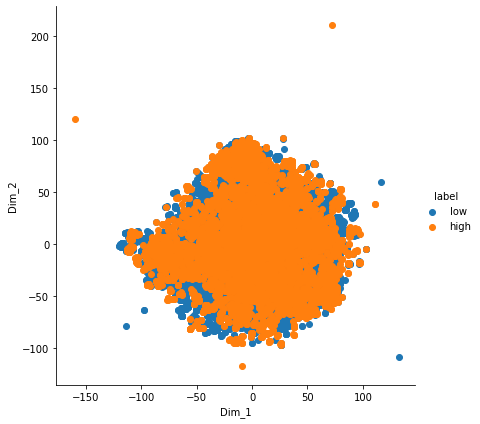

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(X)
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(
    tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1',
                                      'Dim_2').add_legend()
plt.show()

In [ ]:
y = Y2['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = XGBClassifier()
model = RandomForestClassifier(n_estimators=50)

model.fit(X_train, y_train)
predict_train = model.predict(X_train)

In [ ]:
predict_test = model.predict(X_test)

In [ ]:
y_test

8      low
24    high
16    high
0     high
0     high
      ... 
8     high
11    high
11    high
7      low
1      low
Name: valence, Length: 2917, dtype: object

In [ ]:
y_test.map(s2i)

8     0
24    1
16    1
0     1
0     1
     ..
8     1
11    1
11    1
7     0
1     0
Name: valence, Length: 2917, dtype: int64

In [ ]:
accuracy_test = accuracy_score(y_test, predict_test)

In [ ]:
accuracy_test

0.9729173808707576

In [ ]:
x = np.asarray([1, 2, 3, 4])

In [ ]:
pd.Series(x)

0    1
1    2
2    3
3    4
dtype: int64

In [ ]:
s2i = {'low': 0, 'high': 1}

In [ ]:
for emo_dim in emo_dims:
  for degree in ['low', 'high']:
    frac = Y2[(Y2[emo_dim] == degree)].shape[0] / Y2.shape[0]
    print('Fraction of dataset having {} {} = {}'.format(degree, emo_dim, frac))

Fraction of dataset having low valence = 0.45978745286253
Fraction of dataset having high valence = 0.54021254713747
Fraction of dataset having low arousal = 0.5029825162838533
Fraction of dataset having high arousal = 0.49701748371614674
Fraction of dataset having low control = 0.4105587932807679
Fraction of dataset having high control = 0.5894412067192321
Fraction of dataset having low prediction = 0.310593075077134
Fraction of dataset having high prediction = 0.6894069249228659


In [ ]:
X

,ch0_coeff_var,ch0_kurtosis,ch0_skew,ch0_d1_mean,ch0_d1_max,ch0_d2_mean,ch0_d2_max,ch0_ar1,ch0_ar2,ch0_ar3,ch0_hjworth_activity,ch0_hjworth_mobility,ch0_hjworth_complexity,ch0_PMax1,ch0_PMax2,ch0_PMax3,ch0_PMax4,ch0_PRatio1,ch0_PRatio2,ch0_PRatio3,ch0_PRatio4,ch0_cA_mean,ch0_cA_std,ch0_cA_energy,ch0_cA_entropy,ch0_cD_mean,ch0_cD_std,ch0_cD_energy,ch0_cD_entropy,ch1_coeff_var,ch1_kurtosis,ch1_skew,ch1_d1_mean,ch1_d1_max,ch1_d2_mean,ch1_d2_max,ch1_ar1,ch1_ar2,ch1_ar3,ch1_hjworth_activity,...,ch30_PRatio2,ch30_PRatio3,ch30_PRatio4,ch30_cA_mean,ch30_cA_std,ch30_cA_energy,ch30_cA_entropy,ch30_cD_mean,ch30_cD_std,ch30_cD_energy,ch30_cD_entropy,ch31_coeff_var,ch31_kurtosis,ch31_skew,ch31_d1_mean,ch31_d1_max,ch31_d2_mean,ch31_d2_max,ch31_ar1,ch31_ar2,ch31_ar3,ch31_hjworth_activity,ch31_hjworth_mobility,ch31_hjworth_complexity,ch31_PMax1,ch31_PMax2,ch31_PMax3,ch31_PMax4,ch31_PRatio1,ch31_PRatio2,ch31_PRatio3,ch31_PRatio4,ch31_cA_mean,ch31_cA_std,ch31_cA_energy,ch31_cA_entropy,ch31_cD_mean,ch31_cD_std,ch31_cD_energy,ch31_cD_entropy
0,-0.001913,15.005469,3.476950,-0.011978,14.562473,-0.005426,14.937472,-1.779246,1.121202,-0.341956,599.829847,0.118040,7.759557,56.013802,4.604899,1.921906,0.698087,12.163958,29.144920,6.596458,31.540927,-18103.822061,34.528159,1.265113e+11,2.480605e+12,-0.010085,1.298883,651.259105,917.112162,-0.001767,5.531191,1.785631,0.008801,9.406233,-0.004243,10.093731,-1.668597,1.110092,-0.441495,190.687747,...,40.143902,6.762090,45.057346,-6960.305873,24.338914,1.870033e+10,3.309209e+11,-0.005350,1.440423,800.890755,1034.567670,-0.000610,0.303626,-0.255701,-0.003830,6.531238,-0.004161,7.093737,-1.550065,1.147388,-0.597322,60.101021,0.341077,3.358366,18.726083,2.229324,0.767103,0.577095,8.399893,24.411443,3.863012,27.317604,-17960.509795,10.830781,1.245159e+11,2.439498e+12,-0.010807,1.524132,896.714887,1268.285437
1,-0.001343,-1.135068,0.529747,0.064537,7.749986,0.001428,6.218739,-1.582634,1.176391,-0.593757,295.110672,0.127695,8.815461,11.395320,1.679457,1.041164,0.324498,6.785123,10.944792,5.175556,12.557849,-18086.614697,24.304540,1.262707e+11,2.475646e+12,-0.010636,1.298609,650.987985,727.979486,-0.001171,-0.923715,0.051946,-0.011693,6.437488,0.000367,6.312488,-1.600242,1.217304,-0.617062,84.237546,...,18.647833,3.787478,20.170549,-7040.602935,17.335892,1.913417e+10,3.390368e+11,0.012835,1.364439,718.677728,821.029500,-0.000494,-0.246971,0.022410,0.020697,6.374988,0.004447,8.624984,-1.557724,1.205694,-0.647970,39.278756,0.411117,2.798031,6.234830,1.627520,1.327490,0.606406,3.830877,4.696704,2.683877,5.922717,-17948.735199,8.760436,1.243527e+11,2.436137e+12,0.004754,1.441516,802.105070,1023.509482
2,-0.000619,-0.326046,0.078431,0.025098,9.062483,0.006813,12.531227,-1.611264,1.240038,-0.628773,62.314316,0.294762,3.791638,8.899150,2.107174,1.418718,0.341531,4.223262,6.272669,6.169798,7.757936,-18038.565541,11.105047,1.256005e+11,2.461838e+12,-0.016049,1.321130,673.818129,849.430604,-0.000834,-0.319717,0.498362,-0.005786,7.437486,0.005304,8.718734,-1.608750,1.271197,-0.662447,42.767924,...,8.188288,2.410834,9.546469,-7021.286138,8.215676,1.902923e+10,3.370725e+11,0.002406,1.561548,941.237057,1331.858667,-0.001130,-0.927706,0.239413,-0.050521,6.687488,0.008404,8.843734,-1.579043,1.260455,-0.681412,206.177425,0.187561,6.104228,9.604177,1.249670,1.037440,0.420110,7.685370,9.257571,2.974628,10.462141,-17971.977491,20.300307,1.246751e+11,2.442776e+12,0.005473,1.538929,914.176045,1311.529410
3,-0.000499,-0.081596,0.236142,-0.003748,9.312483,0.003549,8.687484,-1.550907,1.072857,-0.521950,40.399920,0.336023,3.359292,7.204403,2.137508,1.118008,0.905036,3.370468,6.443961,2.361792,8.355850,-18026.469004,8.901400,1.254321e+11,2.458368e+12,0.000015,1.165802,524.610082,546.059947,-0.000956,-0.325145,0.198168,0.018986,5.281240,0.001836,6.499988,-1.604430,1.169984,-0.565554,56.102424,...,3.930066,5.432664,5.138187,-7035.362787,11.812308,1.910564e+10,3.385025e+11,-0.013561,1.488405,855.195742,1163.588353,-0.000450,-0.243609,-0.055805,

In [ ]:
Y2

,valence,arousal,control,prediction
0,low,medium,low,medium
1,low,medium,low,medium
2,low,medium,low,medium
3,low,medium,low,medium
4,low,medium,low,medium
...,...,...,...,...
27,high,medium,high,medium
28,high,medium,high,medium
29,high,medium,high,medium
30,high,medium,high,medium
